In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import os
import re

def create_embedding_df(base_dir, label):
    data = []
    for file_name in os.listdir(base_dir):
        file_path = os.path.join(base_dir, file_name)
        if os.path.isfile(file_path) and not re.search("^OUTPUT_ANDROPY_", file_name):
            try:
                with open(file_path, "r") as file:
                    file_content = file.read()
                    data.append({'fileContent': file_content, 'label': label})
            except Exception as e:
                print(f"Error reading file {file_name}: {e}")
    df = pd.DataFrame(data, columns=['fileContent', 'label'])
    return df


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:

# Define base directories
base_dir_train = "/content/drive/MyDrive/Android_Malware_Features-main"
dir_BW = os.path.join(base_dir_train, "Benign", "Features_files")
dir_adware = os.path.join(base_dir_train, "Malware", "Adware", "Features_files")
dir_banking = os.path.join(base_dir_train, "Malware", "Banking", "Features_files")
dir_riskware = os.path.join(base_dir_train, "Malware", "Riskware", "Features_files")

# Create DataFrames
df_train_BW = create_embedding_df(dir_BW, 0)
df_train_adware = create_embedding_df(dir_adware, 1)  # Adware with label 1
df_train_banking = create_embedding_df(dir_banking, 2)  # Banking with label 2
df_train_riskware = create_embedding_df(dir_riskware, 3)  # Riskware with label 3

# Concatenate DataFrames
df_train = pd.concat([df_train_BW, df_train_adware, df_train_banking, df_train_riskware], ignore_index=True)

# Shuffle the DataFrame rows
df_train = df_train.sample(frac=1).reset_index(drop=True)

# Extract texts and labels
texts = df_train['fileContent'].tolist()
labels = df_train['label'].tolist()

print(len(texts))
print(len(dir_BW))
print(len(dir_adware))
print(len(dir_banking))
print(len(dir_riskware))
print(labels)


9994
74
82
83
84
[3, 2, 0, 0, 2, 3, 1, 3, 0, 1, 1, 3, 0, 1, 0, 0, 1, 0, 3, 0, 3, 0, 0, 0, 1, 0, 2, 1, 1, 0, 2, 2, 2, 0, 2, 1, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 3, 3, 0, 3, 2, 2, 1, 0, 1, 2, 0, 0, 3, 3, 3, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 3, 1, 3, 0, 0, 2, 0, 3, 3, 2, 2, 0, 0, 3, 0, 0, 0, 0, 0, 3, 2, 3, 0, 3, 2, 2, 3, 3, 0, 0, 0, 3, 0, 2, 0, 0, 0, 3, 2, 1, 3, 3, 0, 0, 3, 1, 0, 2, 0, 0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 3, 0, 0, 0, 0, 3, 0, 1, 3, 0, 0, 2, 0, 1, 3, 0, 0, 2, 3, 0, 0, 1, 2, 3, 0, 0, 0, 0, 0, 3, 3, 0, 3, 2, 0, 0, 2, 2, 3, 2, 2, 1, 3, 3, 0, 1, 0, 3, 3, 3, 2, 2, 1, 3, 0, 2, 2, 1, 0, 3, 0, 0, 0, 2, 0, 0, 2, 0, 0, 3, 3, 2, 0, 1, 2, 0, 0, 2, 1, 0, 0, 0, 2, 0, 3, 3, 2, 0, 0, 0, 0, 0, 2, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 1, 1, 3, 3, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 2, 3, 3, 0, 0, 2, 3, 0, 1, 2, 1, 3, 3, 0, 0, 2, 0, 2, 3, 2, 2, 3, 3, 0, 0, 0, 0, 3, 1, 1, 2, 3, 2, 0, 0, 3, 0, 1, 2, 2, 0, 2, 0, 0, 2, 2, 0, 1, 0, 0, 0, 2, 1, 2, 1, 1, 1, 2, 0, 3, 2, 0, 1, 2, 3, 2, 1, 2, 0, 2, 2, 0, 0, 1

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

def tokenize_and_sequence_in_batches(full_texts, texts, labels, max_len, max_words, validation_samples, test_samples, batch_size=1000, shuffle=True):
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(full_texts)
    word_index = tokenizer.word_index
    print('{} unique tokens found'.format(len(word_index)))

    num_batches = len(texts) // batch_size + 1
    all_data = []
    all_labels = []

    for i in range(num_batches):
        print(f'Processing batch {i + 1}/{num_batches}')
        batch_texts = texts[i * batch_size: (i + 1) * batch_size]
        batch_labels = labels[i * batch_size: (i + 1) * batch_size]

        sequences = tokenizer.texts_to_sequences(batch_texts)
        data = pad_sequences(sequences, maxlen=max_len)
        batch_labels = np.asarray(batch_labels)

        all_data.append(data)
        all_labels.append(batch_labels)

    all_data = np.vstack(all_data)
    all_labels = np.concatenate(all_labels)

    print('Data tensor shape: {}\nLabel tensor shape: {}'.format(all_data.shape, all_labels.shape))

    if shuffle:
        indices = np.arange(all_data.shape[0])
        np.random.shuffle(indices)
        all_data = all_data[indices]
        all_labels = all_labels[indices]

    x_train_val, x_test, y_train_val, y_test = train_test_split(all_data, all_labels, test_size=test_samples, random_state=42)
    x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=validation_samples, random_state=42)

    return tokenizer, word_index, x_train, y_train, x_val, y_val, x_test, y_test

max_words = 10000
max_len = 100
validation_samples = 0.2
test_samples = 0.1

# Tokenize and sequence data
tokenizer, word_index, x_train, y_train, x_val, y_val, x_test, y_test = tokenize_and_sequence_in_batches(
    texts, texts, labels, max_len, max_words, validation_samples, test_samples
)

print(len(word_index))
print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))
print(len(x_test))
print(len(y_test))


4548138 unique tokens found
Processing batch 1/10
Processing batch 2/10
Processing batch 3/10
Processing batch 4/10
Processing batch 5/10
Processing batch 6/10
Processing batch 7/10
Processing batch 8/10
Processing batch 9/10
Processing batch 10/10
Data tensor shape: (9994, 100)
Label tensor shape: (9994,)
4548138
7195
7195
1799
1799
1000
1000


In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Train a KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)

# Predict on the test set
y_pred = knn.predict(x_test)


In [5]:
# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print performance metrics
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")

# Optional: Print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


Test Accuracy: 0.9080
Test Precision: 0.9089
Test Recall: 0.9080
Test F1 Score: 0.9079
Confusion Matrix:
 [[410   0   0   0]
 [  1 111   5  15]
 [  4   9 196  15]
 [  4  26  13 191]]


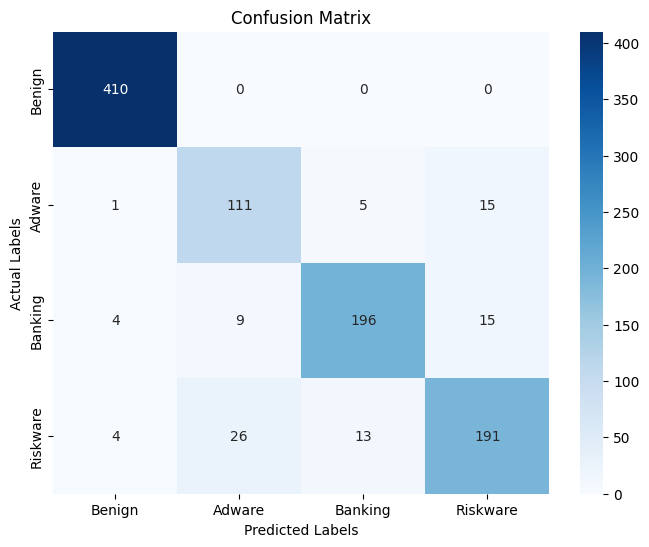

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Benign', 'Adware', 'Banking', 'Riskware'], yticklabels=['Benign', 'Adware', 'Banking', 'Riskware'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


In [9]:
knn.save("/content/drive/MyDrive/KNN_model.h5", save_format='h5')
print("Model saved successfully")

AttributeError: 'KNeighborsClassifier' object has no attribute 'save'